In [1]:
%matplotlib inline

import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time

1
187 4 uint8
(615, 834)


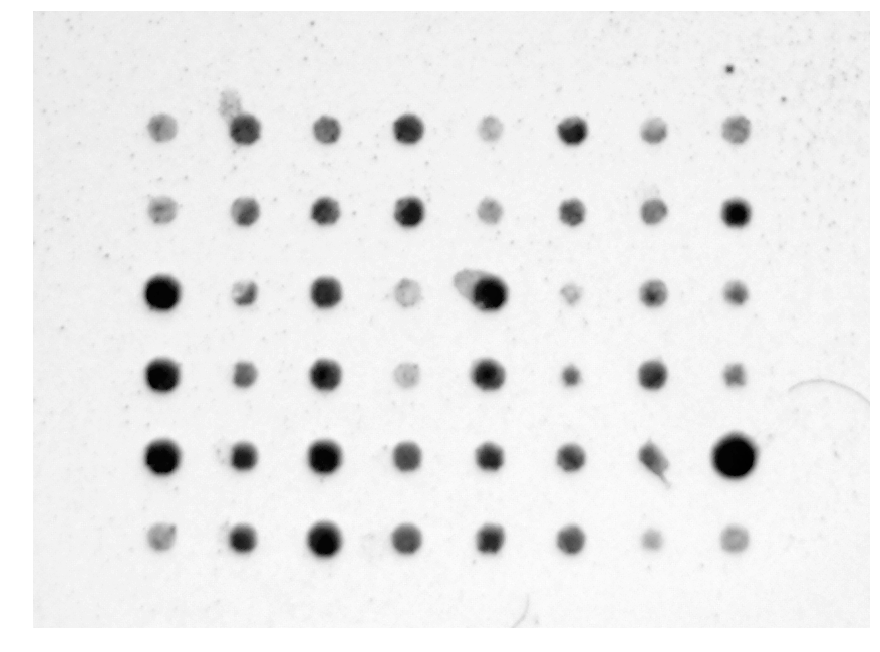

In [8]:
# Load an image
im_dir = '/Users/ivan.ivanov/Documents/images_local/'
ims = glob.glob(os.path.join(im_dir, '*.png'))
print(len(ims))

im = cv.imread(ims[0], cv.IMREAD_GRAYSCALE)
print(im.max(), im.min(), im.dtype)
print(im.shape)

plt.imshow(im, cmap='gray')
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 20]
plt.show()

In [9]:
#Normalize image
im = (im - im.min()) / (im.max() - im.min()) * 255
im = im.astype(np.uint8)
print(im.max(), im.min(), im.dtype)

255 0 uint8


In [105]:
def get_spot_coords(im):
    params = cv.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 0
    params.maxThreshold = 255
    # Filter by Area
    params.filterByArea = True
    params.minArea = 10
    params.maxArea = 5000
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1
    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.5

    detector = cv.SimpleBlobDetector_create(params)

    # Detect blobs.\n",
    keypoints = detector.detect(im)
    
    spots_x = np.zeros(len(keypoints))
    spots_y = np.zeros(len(keypoints))

    for c in range(len(keypoints)):
        pt = keypoints[c].pt
        spots_x[c] = pt[0]
        spots_y[c] = pt[1]
    
    return spots_x, spots_y

In [114]:
# Set up the SimpleBlobdetector with default parameters.\n",
# Spot detection is internionally bad here (increase params.minArea to improve).
# Algorith is robust to many extraneous spots. 
# We can simplify the spot detection significantly

t0 = time.time()
spots_x, spots_y = get_spot_coords(im)

print("Time to detect {} blobs: {:.3f} s".format(len(spots_x), time.time() - t0))

Time to detect 98 blobs: 0.030 s


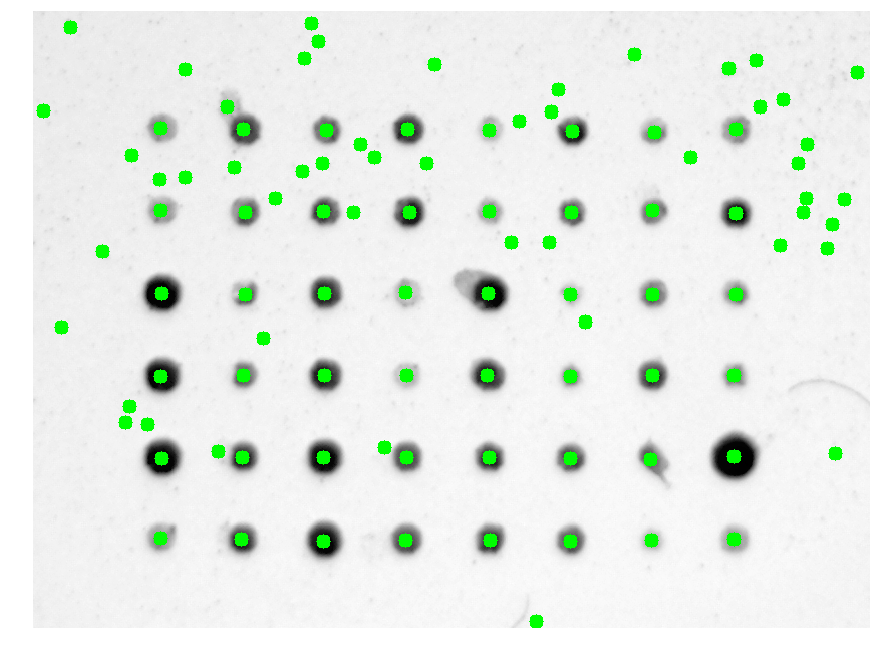

In [115]:
# Draw blobs in image
im_roi = im.copy()
im_roi = cv.cvtColor(im, cv.COLOR_GRAY2RGB)

for c in range(len(spots_x)):
    cv.circle(im_roi,(int(spots_x[c]), int(spots_y[c])), 2, (0, 255, 0), 10)

plt.imshow(im_roi)
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 20]
plt.show()

In [121]:
# find location of fiducial markers only
n_rows = 6
n_cols = 8
spot_dist = 83

fiducial_locations = [(0,0), (0,1), (0,5), (7,0), (7,5)]

im_shape = im.shape
print(im_shape)
# assume grid is approx in the center of the image
cent_y, cent_x = np.array(im_shape)/2
print(cent_x, cent_y)

start_x = cent_x - spot_dist * (n_cols-1) / 2
start_y = cent_y - spot_dist * (n_rows-1) / 2
print(start_x, start_y)

x_vals = np.array([f[0] for f in fiducial_locations]) * spot_dist + start_x
y_vals = np.array([f[1] for f in fiducial_locations]) * spot_dist + start_y
grid_x = x_vals.flatten()
grid_y = y_vals.flatten()
print(grid_x, grid_y)

(615, 834)
417.0 307.5
126.5 100.0
[126.5 126.5 126.5 707.5 707.5] [100. 183. 515. 100. 515.]


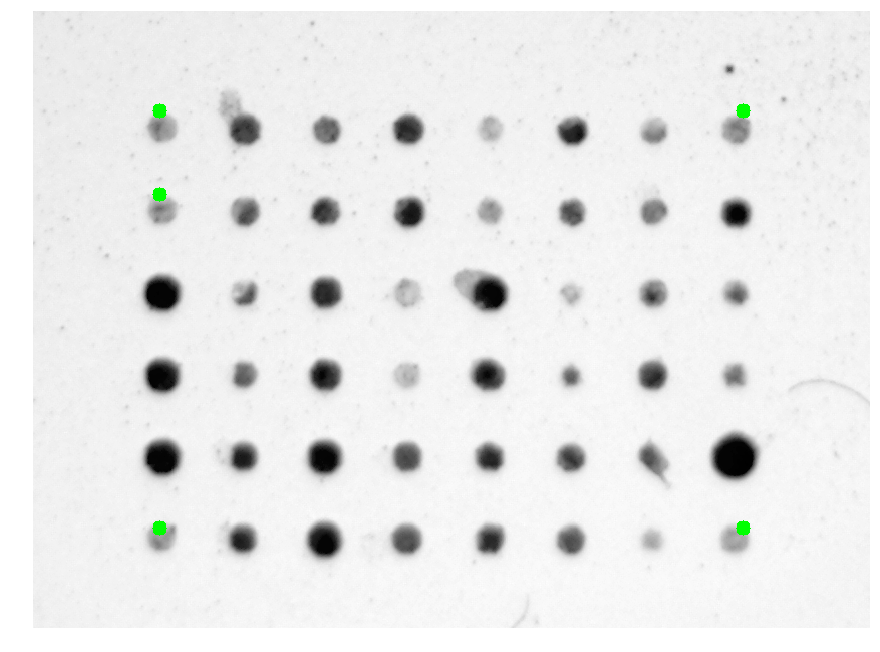

In [122]:
# Draw initial grid in image
im_roi = im.copy()
im_roi = cv.cvtColor(im, cv.COLOR_GRAY2RGB)

for c in range(len(grid_x)):
    cv.circle(im_roi,(int(grid_x[c]), int(grid_y[c])), 2, (0, 255, 0), 10)

plt.imshow(im_roi)
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 20]
plt.show()

In [118]:
def icp(source, target, max_iterate=50, err=1):
    """
    Iterative closest point. Expects x, y coordinates of source in target in shape
    nbr of points x 2
    """
    source = np.expand_dims(source, 0)
    target = np.expand_dims(target, 0)

    src = source.copy().astype(np.float32)
    dst = target.copy().astype(np.float32)
    nbr_src = src.shape[1]
    nbr_dst = dst.shape[1]

    # Initialize kNN module
    knn = cv.ml.KNearest_create()
    labels = np.array(range(nbr_dst)).astype(np.float32)
    knn.train(dst[0], cv.ml.ROW_SAMPLE, labels)
    # Initialize transformation matrix
    t_matrix = np.eye(3)
    t_temp = np.eye(3)
    t_old = t_matrix

    # Iterate while error > threshold
    for i in range(max_iterate):

        # Find closest points
        ret, results, neighbors, dist = knn.findNearest(src[0], 1)
        # Outlier removal
        idxs = np.squeeze(neighbors.astype(np.uint8))
        dist_max = dist.mean() + 1 * dist.std()
        normal_idxs = np.where(dist < dist_max)[0]
        idxs = idxs[normal_idxs]
        # Find rigid transform
        t_iter = cv.estimateRigidTransform(
            src[0, normal_idxs, :],
            dst[0, idxs, :],
            fullAffine=False,
        )
        t_temp[:2] = t_iter
        print(t_iter)
        src = cv.transform(src, t_iter)
        t_matrix = np.dot(t_temp, t_matrix)
        # Estimate diff
        t_diff = sum(sum(abs(t_matrix[:2] - t_old[:2])))
        t_old = t_matrix
        print(i, t_diff)
        if t_diff < err:
            break

    return t_matrix[:2]

In [119]:
t0 = time.time()

source = np.array([grid_x, grid_y]).T
target = np.array([spots_x, spots_y]).T
print(source.shape)
t_matrix = icp(source, target)
print(t_matrix)

grid_estimate = cv.transform(np.expand_dims(source, 0), t_matrix[:2])
print("Time to register grid: {:.3f} s".format(time.time() - t0))

(5, 2)
[[ 0.99572536 -0.01252601  3.46584678]
 [ 0.01252601  0.99572536  4.08872956]]
0 7.588177641101364
[[ 9.87818648e-01  8.59837862e-03  1.60553321e+00]
 [-8.59837862e-03  9.87818648e-01  1.37782704e+01]]
1 15.338605988403492
[[ 1.00012734  0.00104859 -0.62482416]
 [-0.00104859  1.00012734  0.71029507]]
2 1.3150980467299387
[[ 9.99999809e-01  3.43147459e-08  7.68369881e-05]
 [-3.43147459e-08  9.99999809e-01  1.10169627e-04]]
3 0.00018354735956943678
[[ 9.83832856e-01 -2.78075262e-03  4.45886670e+00]
 [ 2.78075262e-03  9.83832856e-01  1.84947493e+01]]
Time to register grid: 0.006 s


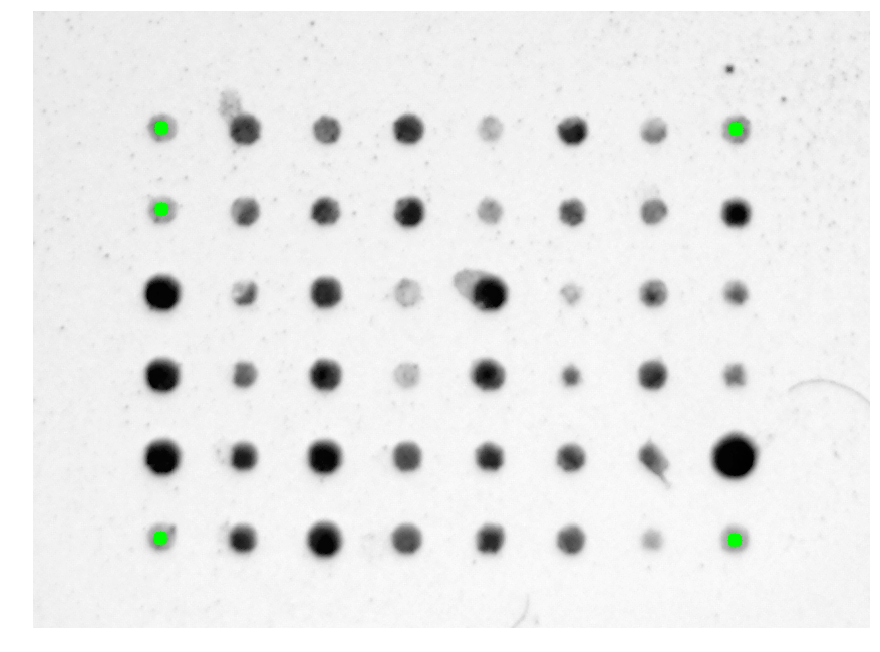

In [120]:
# Draw registered grid in image
reg_x = grid_estimate[0, :, 0]
reg_y = grid_estimate[0, :, 1]
    
im_roi = im.copy()
im_roi = cv.cvtColor(im, cv.COLOR_GRAY2RGB)

for c in range(len(grid_x)):
    cv.circle(im_roi,(int(reg_x[c]), int(reg_y[c])), 2, (0, 255, 0), 10)

plt.imshow(im_roi)
plt.axis('off')
plt.rcParams['figure.figsize'] = [15, 20]
plt.show()

In [ ]:
# Interpolate grid based on locations of fiducial markers
# As already implemented in repo